# Project: '2022 Fall Student Project: Deep Supervised Learning for MRI Reconstruction' 
This project is authored by: Weijie Gan and Yuyang Hu on July 14th, 2022
Project description: main.pdf
<br>In this project, I try to implement the pipeline described in this project.

In [1]:
import numpy as np
import math
import h5py
import matplotlib.pyplot as plt
import scipy
# from scipy import fft
from PIL import Image
# import tensorflow as tf
import skimage

In [2]:
# import pytorch stuff!
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# find out if we can run pytorch w/ GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
filename = "dataset.hdf5"
data = h5py.File(filename,'r')

In this project, the linear model is:
\begin{equation}
\mathbf{\textit{y}} = \mathbf{\textit{PF}}x + \textit{e}
\end{equation}
$\textit{\textbf{x}}\in\mathbb{C}^n$ is an image. It's the ground truth. It's trnOrg
<br>$\mathbf{\textit{y}}\in\mathbb{C}^n$ is a noisy measurement; this is a size-N typle of complex numbers
<br>$\mathbf{\textit{F}}\in\mathbb{C}^{n\times n}$ is the Fourier transform; this is a NxN array complex numbers
<br>$\mathbf{\textit{P}}\in\mathbb{C}^{n\times n}$ is a sampling operator; this is a NxN array complex numbers. It's trnMask
<br>$\mathbf{\textit{e}}\in\mathbb{C}^{n\times n}$ is a noise vector; this is a NxN array complex numbers

In [5]:
with h5py.File('dataset.hdf5', 'r') as hdf:
    keys = list(hdf.keys())
    trnOrg = hdf.get('trnOrg')
    x = np.array(trnOrg)
    trnMask = hdf.get('trnMask')
    P = np.array(trnMask)

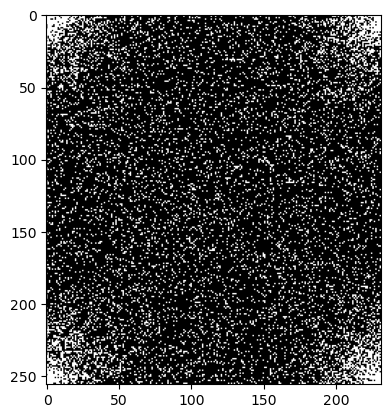

In [6]:
plt.imshow(abs(P[0]), cmap='gray')

In [7]:
print(keys)
print(x.shape)
print(P.shape)
# Note: 360 is number of images <- value of 'N' from the dataset

['trnCsm', 'trnMask', 'trnOrg', 'tstCsm', 'tstMask', 'tstOrg']
(360, 256, 232)
(360, 256, 232)


In [8]:
x_1 = x[1]
x_1.shape

(256, 232)

### First, we calculate $\mathbf{\textit{F}}x$

In [9]:
# Apply Fourier Transform on x, using np.fft.fft
"""There are LOTs of fft() functions in np.fft, so do np.fft.FourierTransformUWant() !"""
Fx = np.fft.fft2(x) #x is 2D image, so need fft2() to do Fourier Transform!
Fx.shape

(360, 256, 232)

### Next, we calculate $\mathbf{\textit{y}}$

In [10]:
# set value of e to 0
e = 0
# compute y
y = P * Fx + e

### Now, we calculate $\widehat{x}_i$ !

In [11]:
# Apply Inverst Fourier Transform on y
x_hat = np.fft.ifft2(y) #x_hat is 2D image, so need ifft2() to do Inverse Fourier Transform!

### Visualize $\widehat{x}_i$ for $i=1$
The output of Fourier Transform has Complex numbers
To visualize the image, we need to take **Absolute value** of the entries in the matrix first!

In [12]:
# Taking absolute value using np.absolute()
x_hat_abs = np.absolute(x_hat)

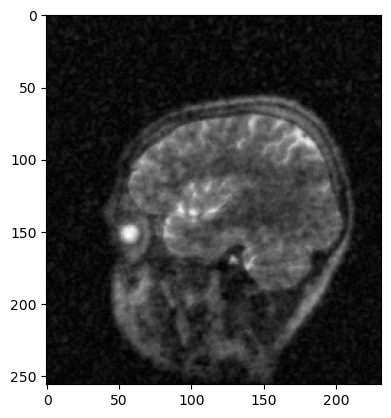

In [20]:
# Visualize the 1st image with plt.imshow()
plt.imshow(x_hat_abs[10], cmap = 'gray')

In [14]:
# lost function?
def loss_fn(x_hat, x):
   L = 0
   for i in range(len(x)):
      l = x_hat[i] - x[i]
      L += l
   return L 

In [15]:
# make Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # turn img (2D mtx) into 1D array
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(256*232, 512), # input dim = #pixels in img, output dim = neurons in next layer
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
# make instance of our nn, move it to the device
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=59392, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Our loss function is:
\begin{equation}
\frac{1}{N}\sum_{i}^N \big\|f_\theta(\widehat{x}_i)-x_i\big\|^2_2
\end{equation}
$f_\theta$ is a Convolutional Neural Network. It maps $\bigl\{\widehat{x}_i=\mathbf{\textit{F}}^{-1}\mathbf{\textit{y}}_i\bigl\}^N_i$ to their desired ground truth $\bigl\{\mathbf{\textit{x}}_i\bigl\}^N_i$
<br>$\mathbf{\textit{F}}^{-1}$ is inverse Fourier transform
<br>$N$ is total number of training samples

In [16]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [17]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [18]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [19]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


NameError: name 'train_dataloader' is not defined